In [18]:
from datetime import datetime

import streamlit as st
import yfinance as yf

import quandl
from fredapi import Fred

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from joblib import load

quandl.ApiConfig.api_key = 'n-JBokomw9UHXTsb1s-j'

fred = Fred(api_key='6a118a0ce0c76a5a1d1ad052a65162d6')

### Create Dataset

In [19]:
# Generate Datasets
# Equity valuations
snp_pe = quandl.get("MULTPL/SP500_PE_RATIO_MONTH")
shiller_pe = quandl.get("MULTPL/SHILLER_PE_RATIO_MONTH")
snp_pe.columns = ["S&P P/E (TTM)"]
shiller_pe.columns = ['Shiller P/E']
pe = snp_pe.join(shiller_pe, how='outer')

# Inflation
head_cpi = fred.get_series('CPIAUCSL', observation_start=snp_pe.index[0]).pct_change(periods=12).to_frame(
    name='CPI') * 100

# Create pandas DataFrame
df = pe.join(head_cpi, how='outer').ffill().dropna()
df = df.join(yf.download('^GSPC', start='1970-01-01', end=datetime.today().strftime('%Y-%m-%d'))['Close'].to_frame(
    name='S&P 500'), how='left')
df['S&P 500 returns'] = df['S&P 500'].pct_change()

[*********************100%***********************]  1 of 1 completed


### Correlation Between Equity Valuations and CPI

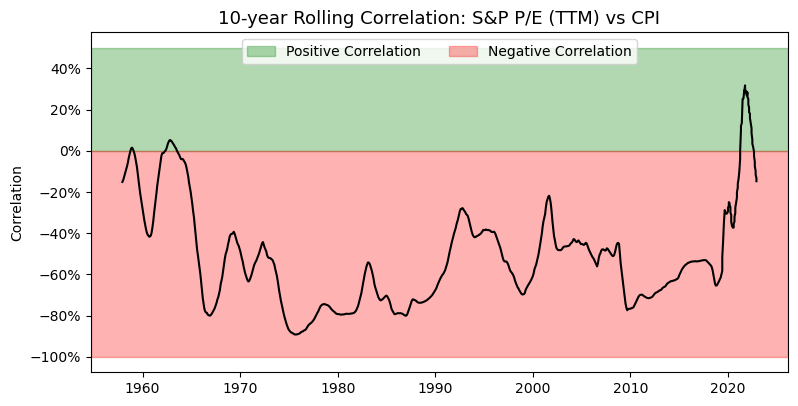

In [20]:
corr_ax = df['S&P P/E (TTM)'].rolling(12*10).corr(df['CPI']).plot(figsize=(9, 5), color='black')
corr_ax.set_title('10-year Rolling Correlation: S&P P/E (TTM) vs CPI', fontsize=13)
corr_ax.set_ylabel('Correlation')

pos = corr_ax.axhspan(0.0005, .5, color='green', alpha=.3, label='Positive Correlation')
neg = corr_ax.axhspan(-0.0005, -1, color='red', alpha=.3, label='Negative Correlation')

corr_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

corr_ax.legend(handles=[pos, neg], loc='upper center', ncol=2)
plt.xticks(rotation=0, ha='center')
corr_fig = plt.gcf()

### Correlation Spike Between Equity Valuations and CPI in 2021/2022

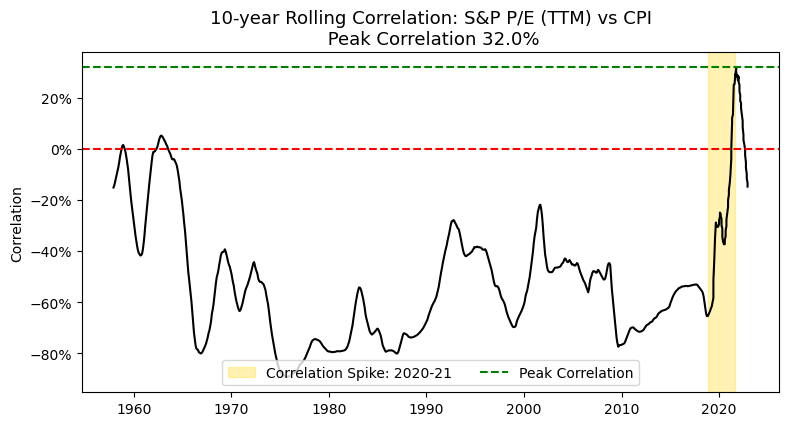

In [21]:
corr_ax = df['S&P P/E (TTM)'].rolling(12*10).corr(df['CPI']).plot(figsize=(9, 5), color='black')
peak_correlation = round(df['S&P P/E (TTM)'].rolling(12*10).corr(df['CPI']).max(), 2)

pos = corr_ax.axvspan('2018-11-01', '2021-09-01', color='gold', alpha=.3, label='Correlation Spike: 2020-21')

peak_corr_label = corr_ax.axhline(peak_correlation, color='green', linestyle='--', label='Peak Correlation')
corr_ax.axhline(0, color='red', linestyle='--')

corr_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

corr_ax.set_title(f'10-year Rolling Correlation: S&P P/E (TTM) vs CPI\n Peak Correlation {peak_correlation*100}%', fontsize=13)
corr_ax.set_ylabel('Correlation')

corr_ax.legend(handles=[pos, peak_corr_label], loc='lower center', ncol=3)
plt.xticks(rotation=0, ha='center')
corr_fig = plt.gcf()

### S&P 500 P/E vs CPI

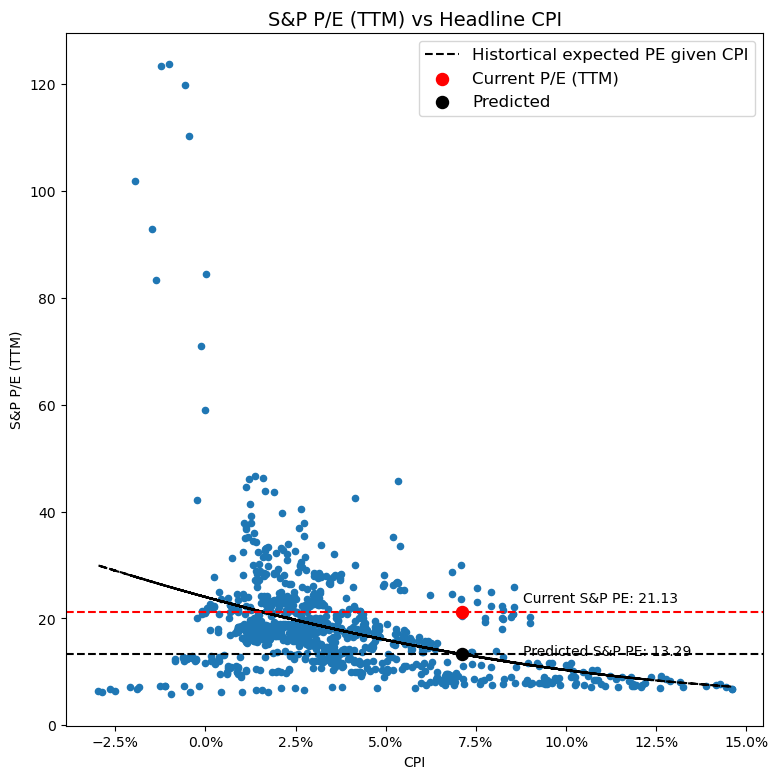

In [22]:
# Predictions
beta_2, beta, alpha = np.polyfit(df['CPI'], df['S&P P/E (TTM)'], 2)
preds = beta_2 * df['CPI'] ** 2 + beta * df['CPI'] + alpha

# Plotting
ax = df.plot(kind='scatter', x='CPI', y='S&P P/E (TTM)', figsize=(9, 9))
ax.plot(df['CPI'], preds, linestyle='--', color='black', label='Histortical expected PE given CPI')

ax.set_title('S&P P/E (TTM) vs Headline CPI', fontsize=14)
ax.axhline(df['S&P P/E (TTM)'].iloc[-1], linestyle='--', color='r')
ax.scatter(y=df['S&P P/E (TTM)'].iloc[-1], x=df['CPI'].iloc[-1], 
           label='Current P/E (TTM)', color='r', marker=".", s=300)


ax.axhline(preds[-1], linestyle='--', color='black')
ax.scatter(y=preds[-1], x=df['CPI'].iloc[-1], 
           label='Predicted', color='black', marker=".", s=300)

ax.annotate(f"Current S&P PE: {df['S&P P/E (TTM)'].iloc[-1]}",
            xy=(8.8, 23))

ax.annotate(f"Predicted S&P PE: {round(preds[-1], 2)}",
            xy=(8.8, 13))

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(fontsize=12)
snp_fig = plt.gcf()

### S&P 500 P/E vs CPI 2021-2022 Highlight

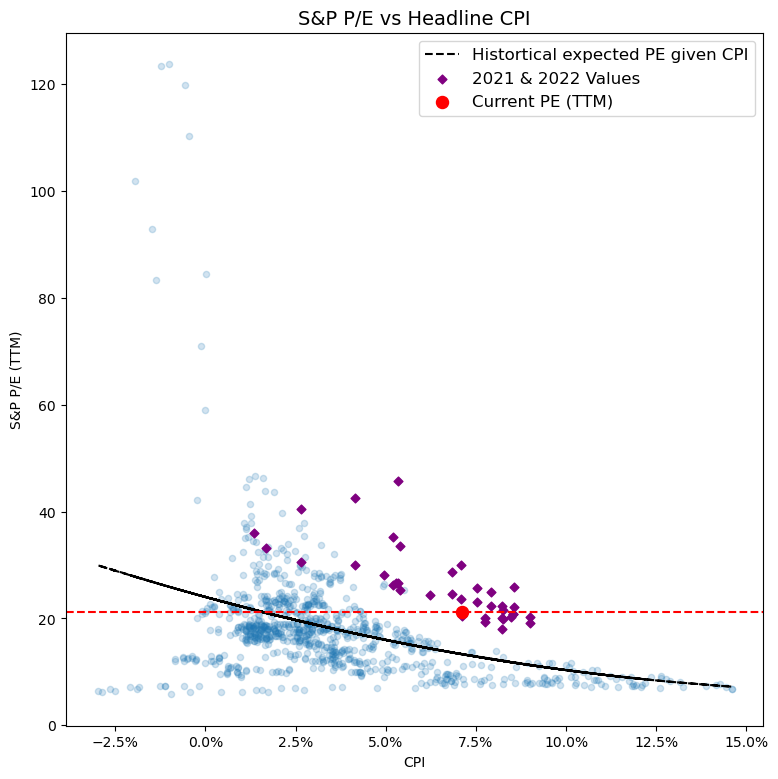

In [23]:
# Plotting
ax = df.plot(kind='scatter', x='CPI', y='S&P P/E (TTM)', figsize=(9, 9), alpha=0.2)
ax.plot(df['CPI'], preds, linestyle='--', color='black', label='Histortical expected PE given CPI')

ax.set_title('S&P P/E vs Headline CPI', fontsize=14)

ax.scatter(y=df[df.index.year.isin([2021, 2022])]['S&P P/E (TTM)'], 
           x=df[df.index.year.isin([2021, 2022])]['CPI'], 
           label="2021 & 2022 Values", color='purple', marker="D", s=20)

ax.axhline(df['S&P P/E (TTM)'].iloc[-1], linestyle='--', color='r')
ax.scatter(y=df['S&P P/E (TTM)'].iloc[-1], x=df['CPI'].iloc[-1], 
           label='Current PE (TTM)', color='r', marker=".", s=300)

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(fontsize=12)
snp_fig_outlier = plt.gcf()

### S&P 500 P/E vs CPI Heatmap

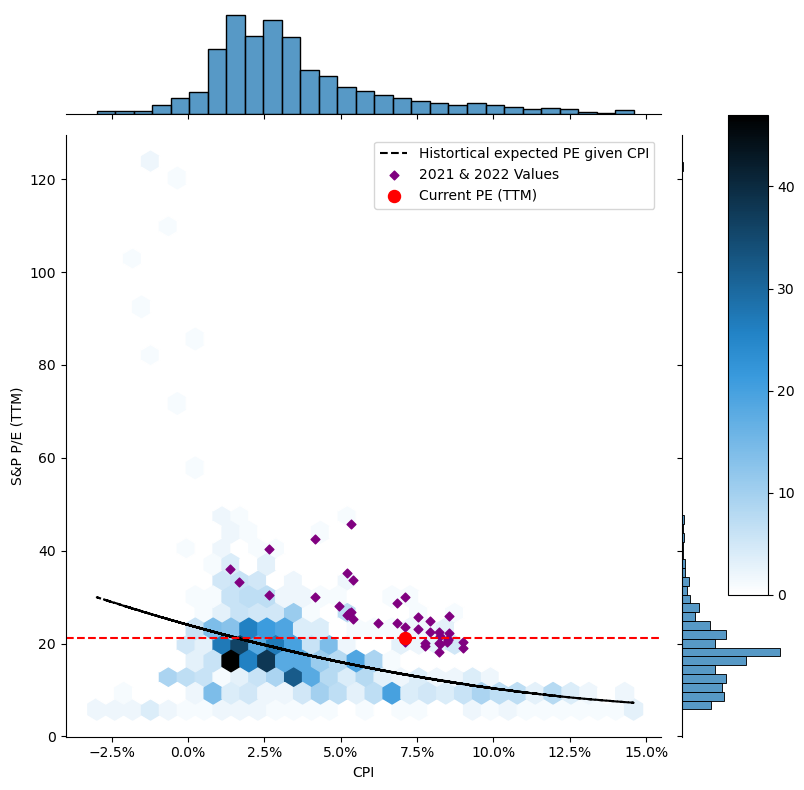

In [24]:
# Plotting
joint_prob_ax_kde = sns.jointplot(data=df, x="CPI", y='S&P P/E (TTM)', height=8, kind="hex", joint_kws={'gridsize': 30})
historical_values = joint_prob_ax_kde.ax_joint.plot(df['CPI'], preds, linestyle='--', color='black', label='Histortical expected PE given CPI')

outliers = joint_prob_ax_kde.ax_joint.scatter(y=df[df.index.year.isin([2021, 2022])]['S&P P/E (TTM)'], 
                                              x=df[df.index.year.isin([2021, 2022])]['CPI'], 
                                              label="2021 & 2022 Values", color='purple', marker="D", s=20)

current = joint_prob_ax_kde.ax_joint.scatter(y=df['S&P P/E (TTM)'].iloc[-1], x=df['CPI'].iloc[-1], 
                                             label='Current PE (TTM)', color='r', marker=".", s=300)

joint_prob_ax_kde.ax_joint.axhline(df['S&P P/E (TTM)'].iloc[-1], linestyle='--', color='r')

cbar_ax = joint_prob_ax_kde.fig.add_axes([.91, .25, .05, .6])  # x, y, width, height
plt.colorbar(cax=cbar_ax)

joint_prob_ax_kde.ax_joint.set_xlim([-4, 15.5])
joint_prob_ax_kde.ax_joint.xaxis.set_major_formatter(mtick.PercentFormatter())

handles = [historical_values[0], outliers, current]
joint_prob_ax_kde.ax_joint.legend(handles=handles)
joint_prob_ax_kde_fig = plt.gcf()

### Load GMM Model

In [25]:
gmm = load('gmm_market_regimes.joblib')

### S&P 500 P/E vs CPI By Market Regime

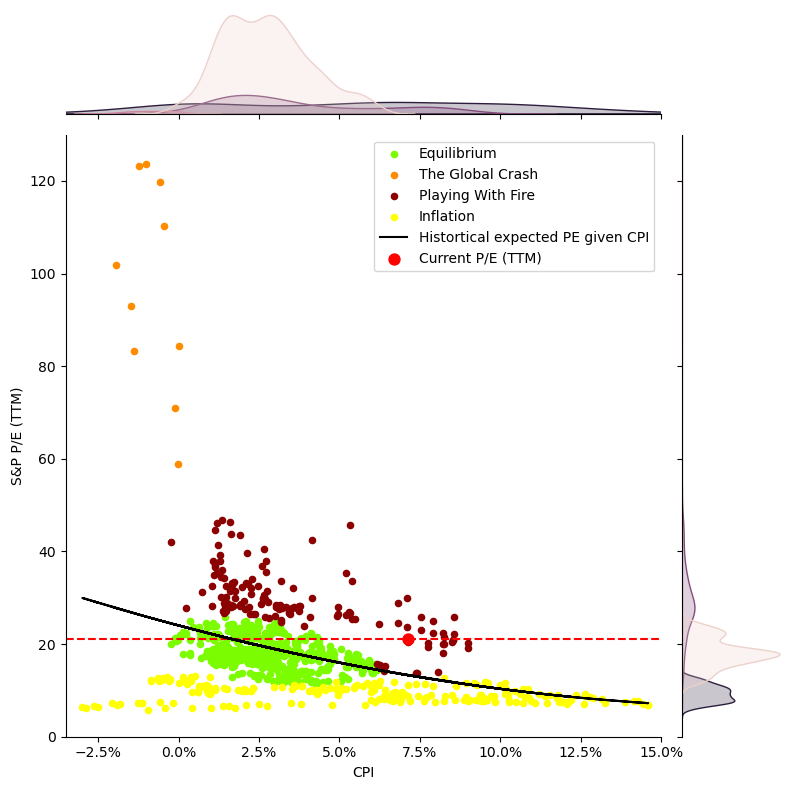

In [26]:
labels = gmm.predict(df[['S&P P/E (TTM)', 'CPI']])
df['labels'] = labels

# plot joint probability 
colours = ["lawngreen", "darkorange", "darkred", "yellow"]
market_regime_labels = ['Equilibrium', 'The Global Crash', 'Playing With Fire', 'Inflation']

joint_prob_ax = sns.jointplot(data=df, x="CPI", y='S&P P/E (TTM)', height=8, hue='labels', joint_kws={"s": 1})
joint_prob_ax.ax_joint.xaxis.set_major_formatter(mtick.PercentFormatter())
joint_prob_ax.ax_joint.axhline(df['S&P P/E (TTM)'].iloc[-1], linestyle='--', color='r')

handles = []
for i, (colour) in enumerate(colours):
    mask = labels == i
    regime_line = joint_prob_ax.ax_joint.scatter(
        x = df['CPI'][mask], 
        y = df['S&P P/E (TTM)'][mask], 
        c=colour,
        label=market_regime_labels[i],
        s=20
    )
    handles.append(regime_line)
    
predictions = joint_prob_ax.ax_joint.plot(df['CPI'], preds, linestyle='solid', color='black', label='Histortical expected PE given CPI')
current = joint_prob_ax.ax_joint.scatter(y=df['S&P P/E (TTM)'].iloc[-1], x=df['CPI'].iloc[-1], 
                                         label='Current P/E (TTM)', color='red', marker=".", s=250)

joint_prob_ax.ax_joint.set_ylim([0, 130])
joint_prob_ax.ax_joint.set_xlim([-3.5, 15])

handles = handles + [predictions[0], current]
joint_prob_ax.ax_joint.legend(handles=handles)
snp_fig_market_regime = plt.gcf()

In [27]:
def plot_in_sample_hidden_states(df, series, log_y=False):
    """
    Plot the adjusted closing prices masked by
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    labels = df['labels']
    # Create the correctly formatted plot
    fig, ax = plt.subplots(figsize=(12, 5))

    colours = ["lawngreen", "darkorange", "darkred", "yellow"]
    market_regime_labels = ['Equilibrium', 'The Global Crash', 'Playing With Fire', 'Inflation']

    for i, (colour) in enumerate(colours):
        mask = labels == i
        ax.plot_date(
            df.index[mask],
            df[series][mask],
            '.', linestyle='none',
            c=colour,
            label=market_regime_labels[i]
        )

    ax.set_title(f"{series} By Market Regime")
    ax.legend(loc='upper center', ncol=4)
    if log_y:
        ax.set_yscale('log')
    return ax

### S&P 500 By Market Regime

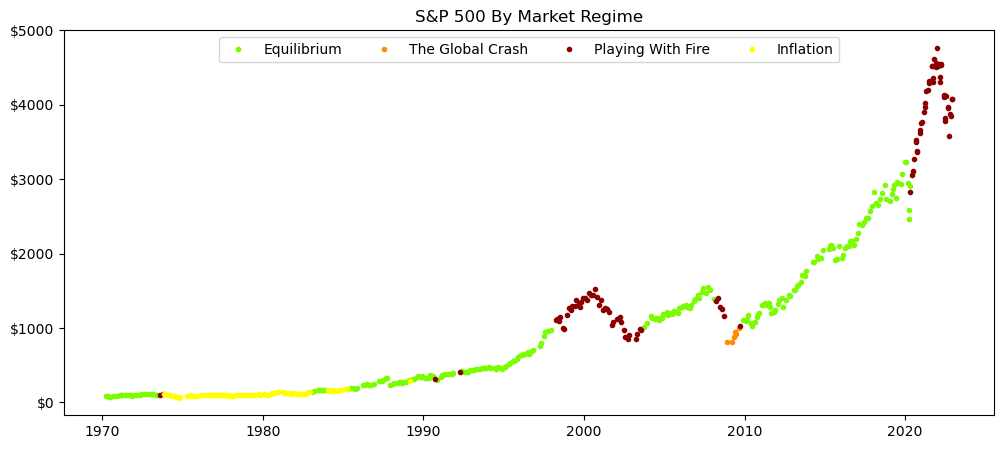

In [28]:
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)
snp_ax = plot_in_sample_hidden_states(df, 'S&P 500')
snp_ax.yaxis.set_major_formatter(tick)
snp_fig = plt.gcf()

### CPI By Market Regime

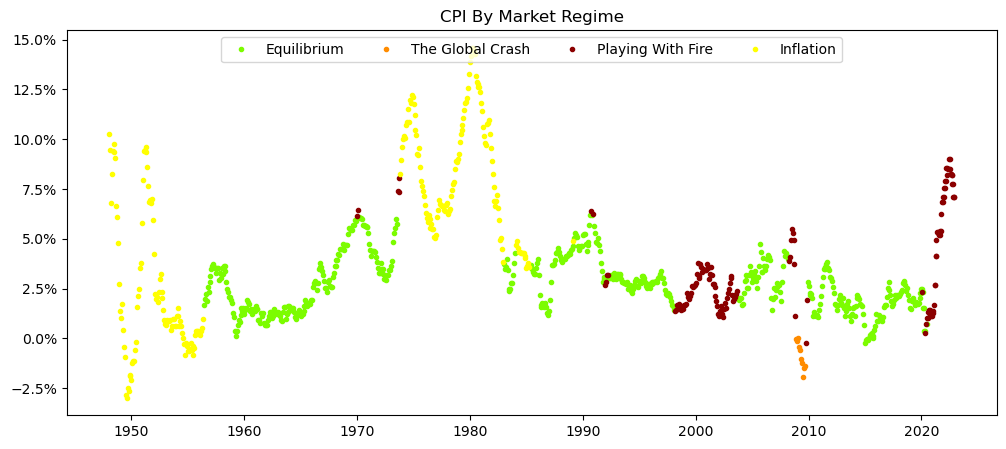

In [29]:
cpi_ax = plot_in_sample_hidden_states(df, 'CPI')
cpi_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
cpi_fig = plt.gcf()

### S&P 500 P/E By Market Regime

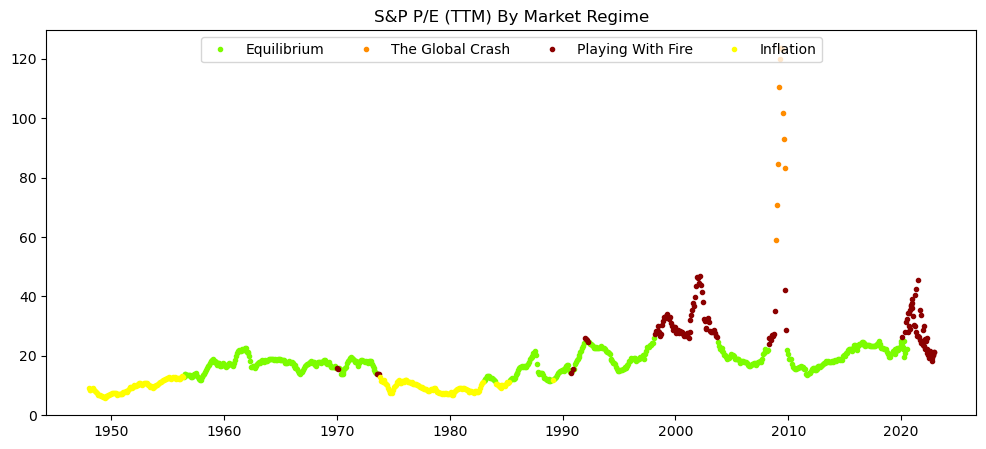

In [30]:
pe_ax = plot_in_sample_hidden_states(df, 'S&P P/E (TTM)')
pe_fig = plt.gcf()

In [31]:
def trillions(x, pos):
    """The two args are the value and tick position."""
    return '${:1.1f}T'.format(x*1e-12)

### Market Regime Probability

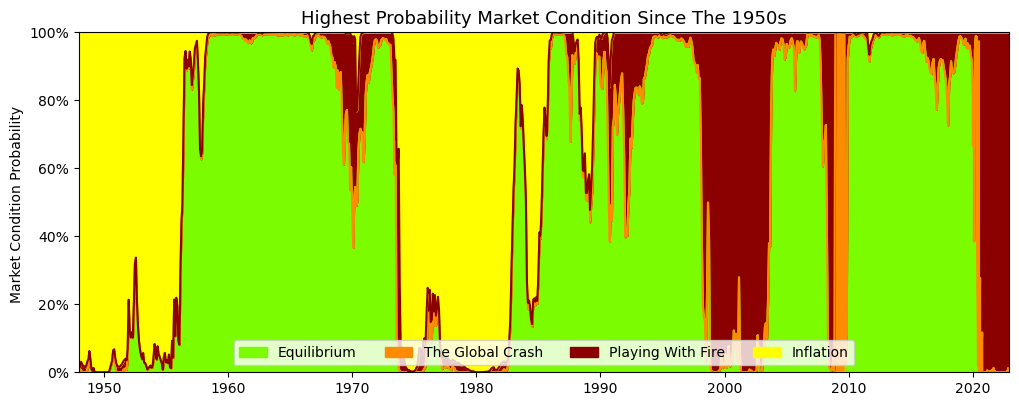

In [32]:
regime_probability_df = pd.DataFrame(gmm.predict_proba(df[['S&P P/E (TTM)', 'CPI']]), index=df.index)
regime_probability_df.columns = market_regime_labels

regime_probability_ax = regime_probability_df.plot(kind='area', color=colours, figsize=(12, 5))
regime_probability_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
regime_probability_ax.legend(ncol=4, loc='lower center')
regime_probability_ax.set_title('Highest Probability Market Condition Since The 1950s', fontsize=13)
regime_probability_ax.margins(x=0, y=0)
regime_probability_ax.set_ylabel('Market Condition Probability ')
plt.xticks(ha='center', rotation=0)

regime_prob_fig = plt.gcf()

### USD Liquidity and Market Regime Probability

(array([14610., 15340., 16071., 16801., 17532., 18262., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

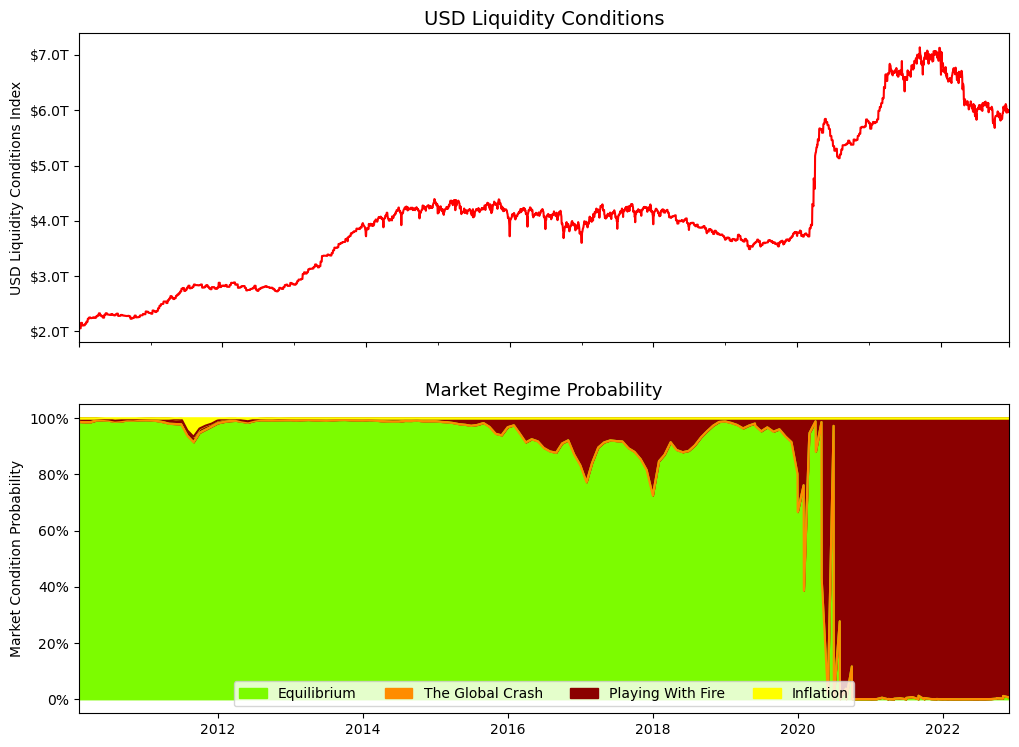

In [33]:
fed_balance_sheet = fred.get_series('WALCL').to_frame(name='FedBal') * 1_000_000 # scale to trillions
rrp_balance = fred.get_series('RRPONTSYD').to_frame(name='RRP') * 1_000_000_000 # scale to trillions
tga = fred.get_series('WTREGEN').to_frame(name='TGA') * 1_000_000_000 # scale to trillions

usd_liquidity_index = fed_balance_sheet.join(rrp_balance, how='outer')
usd_liquidity_index = usd_liquidity_index.join(tga, how='outer').ffill().dropna()
usd_liquidity_index['USD Liquidity Index'] = usd_liquidity_index['FedBal'] - usd_liquidity_index['RRP'] - usd_liquidity_index['TGA']

usd_liquidity_index = usd_liquidity_index[usd_liquidity_index.index > '2010-01-01']

fig = plt.figure(figsize=(12, 10))

liquidity_ax = usd_liquidity_index['USD Liquidity Index'].plot(color='r', ax=plt.subplot(211), )
liquidity_ax.set_title('USD Liquidity Conditions', fontsize=14)
liquidity_ax.yaxis.set_major_formatter(trillions)
liquidity_ax.set_ylabel('USD Liquidity Conditions Index')

rounded_prob_df = round(regime_probability_df, 5)

regime_probability_ax = rounded_prob_df[rounded_prob_df.index > usd_liquidity_index.index[0]].plot(kind='area', 
                                                                                                   ax=plt.subplot(212), 
                                                                                                   color=colours, 
                                                                                                  sharex=True)
regime_probability_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
regime_probability_ax.legend(ncol=4, loc='lower center')
regime_probability_ax.set_title('Market Regime Probability', fontsize=13)
regime_probability_ax.margins(x=0)
regime_probability_ax.set_ylabel('Market Condition Probability')
plt.xticks(ha='center', rotation=0)